In [2]:
! pip install tensorflow-gpu

  Using cached numpy-1.19.5-cp38-cp38-win_amd64.whl (13.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2


In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
print('test')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14270702670012653815
]
test


# 1.2 Import Dpendencies

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# 1.3 Set GPU Growth

In [2]:
gpus = tf.config.experimental.list_logical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
len(gpus)

0

# 1.4 Create Foder Structures

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [8]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2.1 Untar Labelled faced data

In [9]:
# uncompress
!tar -xf lfw.tgz

In [11]:
# move LFW images to the following repo data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# Collect positive and acnhor classe


In [5]:
import uuid
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]

    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Images Directories

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [6]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchor\\0adc3ba6-308d-11ec-9a9f-089798931242.jpg'

## 3.2 Preprcoessing - Scale and resize


In [2]:
def preprocess(file_path):
    bytes_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(bytes_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

## 3.3 Create Labelled Dataset

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
samples = data.as_numpy_iterator()


## 3.4 Build Train and Test partition

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [21]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [22]:
# testong partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [23]:
print(test_data)

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>


# 4 Model

## 4.1 Build Embedding Layer

In [2]:
def make_embedding():
    inp = Input(shape=(100,100,3))
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128,(7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Finale embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [16]:
mod = make_embedding()
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [17]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [3]:
#Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [5]:
l1 = L1Dist()


## 4.3 Make Siamese Model

In [13]:
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # combine siamese distance
    siamese_layer = L1Dist()
    siamese_layer.__name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetork')
    

In [21]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]      

# 5. Training

## 5.1 Setup Loss and Optimize

In [22]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [23]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Esablish checkpoint

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build train step function

In [30]:
@tf.function # Compile a function into a callable Tensorflow Graph
def train_step(batch):
    
    with tf.GradientTape() as tape:
        # get anchor and positive/negative image
        X = batch[:2]
        # get label 
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y ,yhat)
    
    # calculate gradiet
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights andd apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))


    return loss

## 5.4 Build Training Looop

In [31]:
def train(data, EPOCHS):
    # loop epochs
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch{}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        # loop each batch
        for idx, batch in enumerate(data):
            # run train step
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [34]:
EPOCHS = 20

In [35]:
train(train_data, EPOCHS)


 Epoch1/20
27/27 [==============================] - 402s 15s/step

 Epoch2/20
27/27 [==============================] - 403s 15s/step

 Epoch3/20
27/27 [==============================] - 402s 15s/step

 Epoch4/20
27/27 [==============================] - 402s 15s/step

 Epoch5/20
27/27 [==============================] - 400s 15s/step

 Epoch6/20
27/27 [==============================] - 401s 15s/step

 Epoch7/20
27/27 [==============================] - 401s 15s/step

 Epoch8/20
27/27 [==============================] - 401s 15s/step

 Epoch9/20
27/27 [==============================] - 386s 14s/step

 Epoch10/20
27/27 [==============================] - 378s 14s/step

 Epoch11/20
27/27 [==============================] - 383s 14s/step

 Epoch12/20
27/27 [==============================] - 380s 14s/step

 Epoch13/20
27/27 [==============================] - 377s 14s/step

 Epoch14/20
27/27 [==============================] - 379s 14s/step

 Epoch15/20
27/27 [==============================] - 379

# 6. Evaluate the model

In [27]:
from tensorflow.keras.metrics import Precision, Recall

In [26]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [56]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[1.1965137e-09],
       [2.2039160e-07],
       [5.7978933e-10],
       [6.4173680e-09],
       [5.3821787e-09],
       [1.0000000e+00],
       [5.5184088e-08],
       [9.9964452e-01],
       [2.1438790e-08],
       [1.5733496e-06],
       [2.0122354e-06],
       [9.9859720e-01],
       [1.0946235e-07],
       [9.9713516e-01],
       [3.1174133e-10],
       [9.9633217e-01]], dtype=float32)

In [57]:
# Post processing the result
[1 if prediction >0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]

In [58]:
m = Recall()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

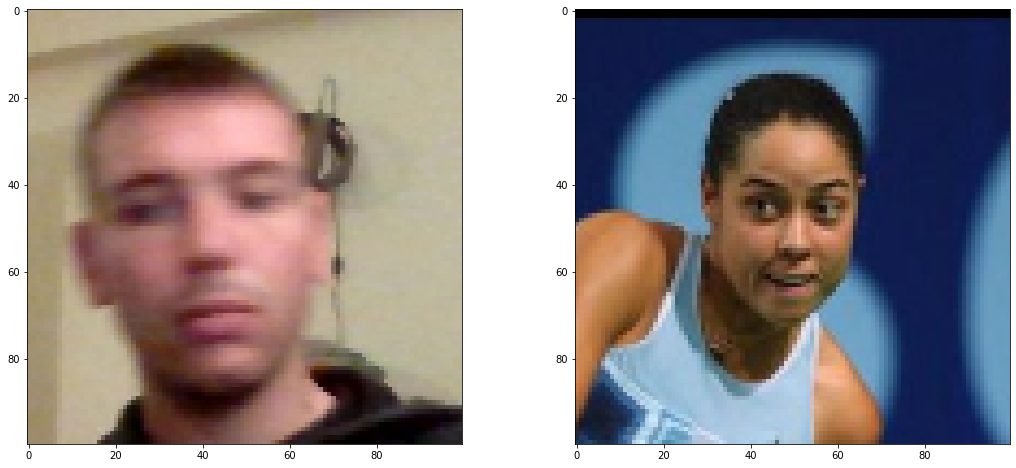

In [59]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

# 7. Save Model

In [61]:
siamese_model.save('siamesemodel.h5')

In [4]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                    custom_objects={'L1Dist': L1Dist,
                                                    'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [29]:
# Make predictions with loaded model
model.predict([test_input, test_val])

array([[1.3839514e-09],
       [3.6828653e-09],
       [9.9987066e-01],
       [2.4018127e-09],
       [9.5802523e-07],
       [9.9968171e-01],
       [1.2618964e-09],
       [2.6220605e-06],
       [9.2332803e-06],
       [2.4906304e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.1268606e-09],
       [4.1671447e-07],
       [2.1788494e-06],
       [9.5284796e-01]], dtype=float32)

# 8. Real Time test

## 8.1 Verifciation function

In [1]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images',image))

        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    return results, verified

## 8.2 OpenCV Real Time verification

In [6]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    cv2.imshow('Verification', frame)


    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_images','input_image.jpg'), frame)

        # run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)


    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


True
True
True
False
